#**Import libraries**

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/EVA8/Session 5 - Assignment'

/content/drive/MyDrive/EVA8/Session 5 - Assignment


In [4]:
from model import NetWithGN, NetWithLN, NetWithBN

#**Data Transformations (without normalization)** 

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor()
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor()
                                       ])


# **Dataset and Creating Train/Test Split (without normalization)**

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# **Dataloader Arguments & Test/Train Dataloaders (without normalization)**


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#**Data Transformations (with normalization)**

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])


# **Dataset and Creating Train/Test Split (with normalization)**

In [9]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# **Dataloader Arguments & Test/Train Dataloaders (with normalization)**


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#**plot some images to see which image augmentation to use (with normalization)**
We will plot some images to see which image augmentation technique we can use

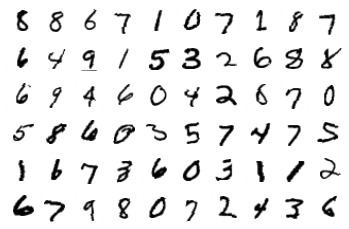

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

**Training and Testing**

In [12]:
from tqdm import tqdm

class TrainAndTest:
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.misclassified_images = []

  def train(self, model, device, train_loader, optimizer, epoch, task):
    """
    this function will train the model 
    params model: model to be used for training
    params devide: can be GPU or CPu
    params train_loader: traininig data
    optimiser: optimiser to be used
    epoch: epoch number
    task: task for which training will be performed (can be 'GN' for Group normalisation, 'LN' for Layer normalisation or 'BN' for batch normalisation. 
          If this is 'BN' then only we will do L1 regularisation)
    returns: train_acc, train_losses
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      # Calculate 'L1' regularization loss if task == 'BN'
      if(task=='BN'):
        lambda_l1 = 0.01
        l1_reg = 0
        for param in model.parameters():
            l1_reg += torch.norm(param, p=1)
        l1_loss = lambda_l1 * l1_reg
        loss += l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
    return self.train_acc, self.train_losses

  def test(self, model, device, test_loader):
    """
    this function will test the model in test data
    params model: model to be tested
    params devide: can be GPU or CPU
    params test_loader: test data 
    returns: test_acc, test_losses and misclassified_images
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            indices = [item[0] for item in (pred.eq(target.view_as(pred)) == False).nonzero().tolist()]
            mis_imgs = data[indices, :, :, :]
            self.misclassified_images.extend(mis_imgs)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    self.test_acc.append(100. * correct / len(test_loader.dataset))
    return self.test_acc, self.test_losses, self.misclassified_images

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [14]:
def get_model(task_name):
  """
  this function will return the model based on the task_name
  params task_name: 'GN', 'LN' or 'BN'
  returns: model
  """
  if (task_name=='GN'):
    print("You have chosen GN, Now we will perform Group Normalisation")
    model =  NetWithGN().to(device)
  elif(task_name=='LN'):
    print("You have chosen LN, Now we will perform Layer Normalisation")
    model =  NetWithLN().to(device)
  elif(task_name=='BN'):
    print("You have chosen BN, Now we will perform Batch Normalisation with L1 regularisation")
    model =  NetWithBN().to(device)
  return model

In [15]:
from torch.optim.lr_scheduler import StepLR
def perform_tasks(task_name):
  """
  performs the train and test on the data 
  params task_name: (GN, LN, BN)
  returns: train_acc, train_losses, test_acc, test_losses, misclassified_images
  """
  model = get_model(task_name) #get the model based on the task name (GN, LN, BN)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #declare optimiser
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #learning rate scheduler
  train_test_obj = TrainAndTest() #create the obejct of TrainAndTest class
  EPOCHS = 20
  for epoch in range(EPOCHS): #for each epoch
      print("EPOCH:", epoch)
      train_acc, train_losses = train_test_obj.train(model, device, train_loader, optimizer, epoch, task_name) #model train using the selected model 
      scheduler.step() #update weights
      test_acc, test_losses, misclassified_images = train_test_obj.test(model, device, test_loader) #test model using test data
  return train_acc, train_losses, test_acc, test_losses, misclassified_images

In [25]:
import random
def show_misclassified_images(misclassified_images, task_name):
  """
  show 10 misclassified images
  """
  misclassified_images = random.sample(misclassified_images, 10)
  fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8, 12))
  axs = axs.ravel()

  for i, ax in enumerate(axs):
      if i < 10:
          ax.imshow(misclassified_images[i].cpu().numpy().squeeze(), cmap='gray')
          ax.set_title('Image ' + str(i))

  plt.tight_layout()
  plt.suptitle(f'Misclassified images using {task_name}', y=1.02)
  plt.show()

**Group Normalisation**

In [17]:
task_name = 'GN'
train_acc_GN, train_losses_GN, test_acc_GN, test_losses_GN, misclassified_images_GN = perform_tasks(task_name)
train_losses_GN = [i.item() for i in train_losses_GN]

You have chosen GN, Now we will perform Group Normalisation
EPOCH: 0


Loss=0.10099100321531296 Batch_id=468 Accuracy=85.39: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]



Test set: Average loss: 0.0715, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.2208859771490097 Batch_id=468 Accuracy=95.34: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]



Test set: Average loss: 0.0558, Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Loss=0.18397341668605804 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0422, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.07414469867944717 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]



Test set: Average loss: 0.0311, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.21478994190692902 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]



Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.06412800401449203 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]



Test set: Average loss: 0.0286, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.04658593237400055 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]



Test set: Average loss: 0.0209, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.06047584488987923 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0198, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.09823957830667496 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0212, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.05961877107620239 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0198, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.04525679349899292 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]



Test set: Average loss: 0.0205, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.04970937967300415 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0187, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.06041562557220459 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.0187, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.032848261296749115 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.0186, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.08620817214250565 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]



Test set: Average loss: 0.0188, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.05799892917275429 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]



Test set: Average loss: 0.0187, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.06123394891619682 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]



Test set: Average loss: 0.0186, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.04270932078361511 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]



Test set: Average loss: 0.0187, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.06956575065851212 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0186, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.07965157181024551 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:17<00:00, 26.13it/s]



Test set: Average loss: 0.0186, Accuracy: 9926/10000 (99.26%)



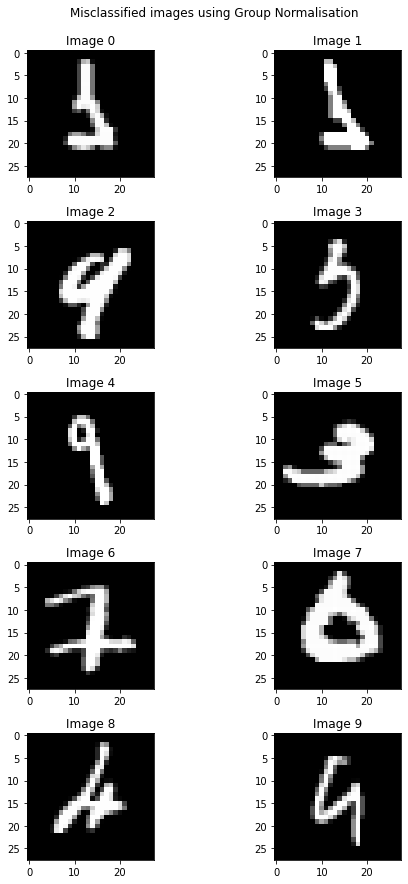

In [26]:
show_misclassified_images(misclassified_images_GN, 'Group Normalisation')

In [19]:
task_name = 'LN'
train_acc_LN, train_losses_LN, test_acc_LN, test_losses_LN, misclassified_images_LN = perform_tasks(task_name)
train_losses_LN = [i.item() for i in train_losses_LN]

You have chosen LN, Now we will perform Layer Normalisation
EPOCH: 0


Loss=0.20948584377765656 Batch_id=468 Accuracy=82.77: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]



Test set: Average loss: 0.1382, Accuracy: 9667/10000 (96.67%)

EPOCH: 1


Loss=0.16525419056415558 Batch_id=468 Accuracy=94.24: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0946, Accuracy: 9731/10000 (97.31%)

EPOCH: 2


Loss=0.09798494726419449 Batch_id=468 Accuracy=95.23: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]



Test set: Average loss: 0.0731, Accuracy: 9785/10000 (97.85%)

EPOCH: 3


Loss=0.06869831681251526 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]



Test set: Average loss: 0.0609, Accuracy: 9827/10000 (98.27%)

EPOCH: 4


Loss=0.14128398895263672 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]



Test set: Average loss: 0.0583, Accuracy: 9834/10000 (98.34%)

EPOCH: 5


Loss=0.13747243583202362 Batch_id=468 Accuracy=96.43: 100%|██████████| 469/469 [00:18<00:00, 24.99it/s]



Test set: Average loss: 0.0540, Accuracy: 9830/10000 (98.30%)

EPOCH: 6


Loss=0.0532214492559433 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]



Test set: Average loss: 0.0468, Accuracy: 9858/10000 (98.58%)

EPOCH: 7


Loss=0.12967424094676971 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]



Test set: Average loss: 0.0455, Accuracy: 9868/10000 (98.68%)

EPOCH: 8


Loss=0.25995495915412903 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]



Test set: Average loss: 0.0451, Accuracy: 9875/10000 (98.75%)

EPOCH: 9


Loss=0.04723837599158287 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:18<00:00, 24.98it/s]



Test set: Average loss: 0.0451, Accuracy: 9856/10000 (98.56%)

EPOCH: 10


Loss=0.055987898260354996 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0450, Accuracy: 9863/10000 (98.63%)

EPOCH: 11


Loss=0.05027118697762489 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:18<00:00, 25.22it/s]



Test set: Average loss: 0.0431, Accuracy: 9866/10000 (98.66%)

EPOCH: 12


Loss=0.08208596706390381 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0453, Accuracy: 9864/10000 (98.64%)

EPOCH: 13


Loss=0.0700497254729271 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]



Test set: Average loss: 0.0430, Accuracy: 9865/10000 (98.65%)

EPOCH: 14


Loss=0.10827362537384033 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]



Test set: Average loss: 0.0423, Accuracy: 9878/10000 (98.78%)

EPOCH: 15


Loss=0.09508830308914185 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]



Test set: Average loss: 0.0453, Accuracy: 9852/10000 (98.52%)

EPOCH: 16


Loss=0.10061508417129517 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 0.0452, Accuracy: 9871/10000 (98.71%)

EPOCH: 17


Loss=0.09726373106241226 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0436, Accuracy: 9873/10000 (98.73%)

EPOCH: 18


Loss=0.11846256256103516 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0441, Accuracy: 9861/10000 (98.61%)

EPOCH: 19


Loss=0.07192239910364151 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s]



Test set: Average loss: 0.0456, Accuracy: 9869/10000 (98.69%)



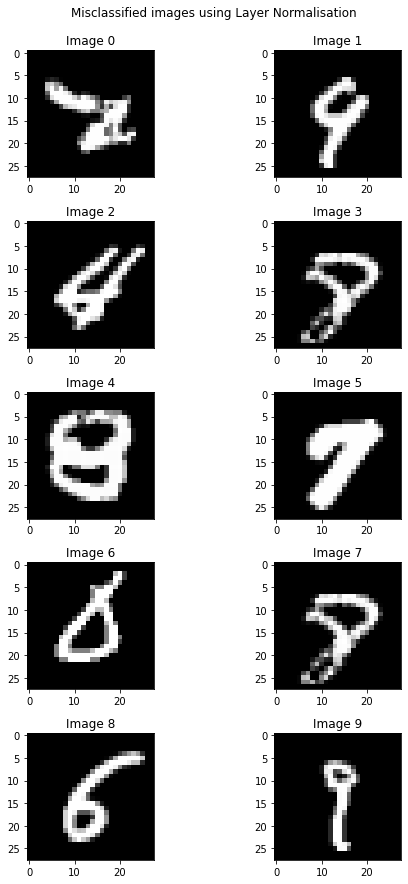

In [27]:
show_misclassified_images(misclassified_images_LN, 'Layer Normalisation')

**Bacth Normalisation with L1 regularisation**

In [21]:
task_name = 'BN'
train_acc_BN, train_losses_BN, test_acc_BN, test_losses_BN, misclassified_images_BN = perform_tasks(task_name)
train_losses_BN = [i.item() for i in train_losses_BN]

You have chosen BN, Now we will perform Batch Normalisation with L1 regularisation
EPOCH: 0


Loss=1.754043698310852 Batch_id=468 Accuracy=82.95: 100%|██████████| 469/469 [00:19<00:00, 23.65it/s]



Test set: Average loss: 0.8237, Accuracy: 8164/10000 (81.64%)

EPOCH: 1


Loss=1.1470924615859985 Batch_id=468 Accuracy=89.70: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]



Test set: Average loss: 0.9903, Accuracy: 6651/10000 (66.51%)

EPOCH: 2


Loss=1.0104014873504639 Batch_id=468 Accuracy=90.13: 100%|██████████| 469/469 [00:19<00:00, 24.20it/s]



Test set: Average loss: 0.6918, Accuracy: 7792/10000 (77.92%)

EPOCH: 3


Loss=1.466449499130249 Batch_id=468 Accuracy=89.86: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]



Test set: Average loss: 5.0010, Accuracy: 3986/10000 (39.86%)

EPOCH: 4


Loss=1.0603042840957642 Batch_id=468 Accuracy=88.52: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]



Test set: Average loss: 0.9016, Accuracy: 6894/10000 (68.94%)

EPOCH: 5


Loss=0.9505712985992432 Batch_id=468 Accuracy=89.60: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s]



Test set: Average loss: 0.5401, Accuracy: 8736/10000 (87.36%)

EPOCH: 6


Loss=0.7473505735397339 Batch_id=468 Accuracy=92.27: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]



Test set: Average loss: 0.1856, Accuracy: 9609/10000 (96.09%)

EPOCH: 7


Loss=0.8415389657020569 Batch_id=468 Accuracy=92.08: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]



Test set: Average loss: 0.1889, Accuracy: 9511/10000 (95.11%)

EPOCH: 8


Loss=0.721432089805603 Batch_id=468 Accuracy=92.04: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]



Test set: Average loss: 0.2357, Accuracy: 9407/10000 (94.07%)

EPOCH: 9


Loss=0.7655919790267944 Batch_id=468 Accuracy=91.95: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]



Test set: Average loss: 0.3678, Accuracy: 8989/10000 (89.89%)

EPOCH: 10


Loss=0.8030099868774414 Batch_id=468 Accuracy=91.96: 100%|██████████| 469/469 [00:19<00:00, 23.83it/s]



Test set: Average loss: 0.1611, Accuracy: 9645/10000 (96.45%)

EPOCH: 11


Loss=0.7599208354949951 Batch_id=468 Accuracy=91.95: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]



Test set: Average loss: 0.1932, Accuracy: 9636/10000 (96.36%)

EPOCH: 12


Loss=0.6952192187309265 Batch_id=468 Accuracy=93.25: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]



Test set: Average loss: 0.1414, Accuracy: 9698/10000 (96.98%)

EPOCH: 13


Loss=0.7075787782669067 Batch_id=468 Accuracy=93.10: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]



Test set: Average loss: 0.1280, Accuracy: 9736/10000 (97.36%)

EPOCH: 14


Loss=0.6282301545143127 Batch_id=468 Accuracy=93.18: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.1265, Accuracy: 9710/10000 (97.10%)

EPOCH: 15


Loss=0.6804661750793457 Batch_id=468 Accuracy=93.08: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]



Test set: Average loss: 0.1502, Accuracy: 9683/10000 (96.83%)

EPOCH: 16


Loss=0.6936613321304321 Batch_id=468 Accuracy=93.09: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.1341, Accuracy: 9741/10000 (97.41%)

EPOCH: 17


Loss=0.744918704032898 Batch_id=468 Accuracy=93.08: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]



Test set: Average loss: 0.1276, Accuracy: 9713/10000 (97.13%)

EPOCH: 18


Loss=0.6583273410797119 Batch_id=468 Accuracy=93.43: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]



Test set: Average loss: 0.1245, Accuracy: 9744/10000 (97.44%)

EPOCH: 19


Loss=0.6359788179397583 Batch_id=468 Accuracy=93.46: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.1252, Accuracy: 9746/10000 (97.46%)



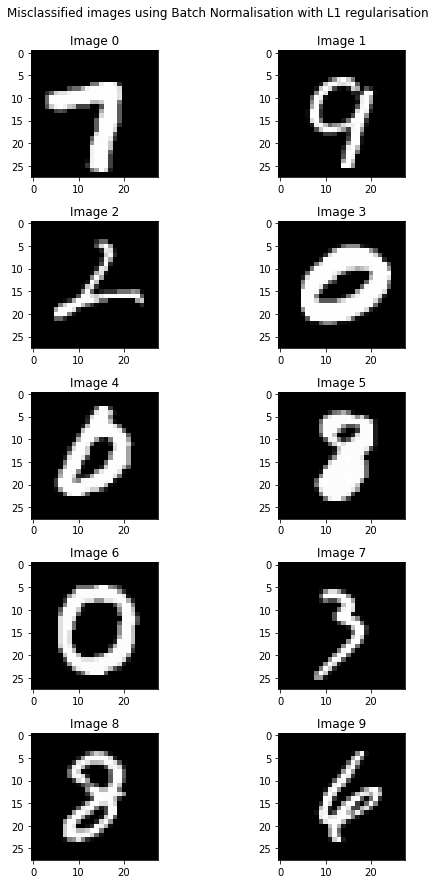

In [28]:
show_misclassified_images(misclassified_images_BN, 'Batch Normalisation with L1 regularisation')

**Comparing loses and accuracies**

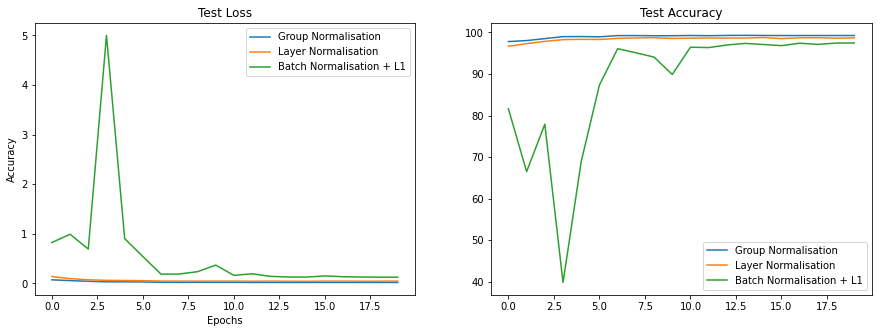

In [23]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_losses_GN, label='Group Normalisation')
axs[0].plot(test_losses_LN, label = 'Layer Normalisation')
axs[0].plot(test_losses_BN, label = 'Batch Normalisation + L1')
axs[0].set_title("Test Loss")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(test_acc_GN, label='Group Normalisation')
axs[1].plot(test_acc_LN, label = 'Layer Normalisation')
axs[1].plot(test_acc_BN, label = 'Batch Normalisation + L1')
axs[1].set_title("Test Accuracy")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[1].legend()